## The Sugarscape.

The "Sugarscape" is a landscape (in the form of a lattice) where **sugar grows in each cell**.

The sugar provides energy and wealth.

**Agents explore the landscape** and, while doing it, harvest the sugar. 

- Each round, each agent move once. They move sequentially. Each round, the order in which the agent move is random.

- Two agents can't share the same cell: if an agent can't move on a free cell within its range, it remains in the cell it occupies.

- Each agent pays a metabilic cost to remain alive and move on the sugarscape. When their energy (that corresponds to their sugar level) falls below zero then they die of starvation.

At the end of each round, the **landscape regrowth the sugar** according to the growth rule $G_{\rm g}$.

In our implementation we also combine agents genetics randomly after a certain amount of time. In order to analyze which traits are better suited for survival. 

### Features of the Sugarscape.

We start from the classical implementation: 

- squared lattice $N \times N$

- sugar full capacity of each cell: from 0 to 4

- landscape shaped like two sugar-hills

- rule $G_{\infty}$: at the end of each round, the sugar regrowth instantly to the maximum capacity of each cell.


### Agents on the Sugarscape.

Agents on sugarsape have the following features:

- vision: $v$ (uniform distribution $\in \{1, 2, ..., 6 \}$)
- sugar: $s$ (uniform distribution $\in \{5, 6, ... 25 \}$)
- metabolism: $m$ (uniform distribution $\in \{1, 2, 3, 4 \}$)

The vision determines the motion range.

The sugar is a reservoir of energy.

The metabolism represents the enegy each agents demands per round to survive. 



In [1]:
import numpy as np
import pandas as pd
from random import sample

In [2]:
def move_agents(SuSca, agents, N):
    """
    Function to move the agents on the sugarscape using a pandas DataFrame.
    Implements one round where all agents move once, ensuring no two agents occupy the same cell.
    
    Parameters
    ==========
    SuSca : 2D numpy array representing the sugarscape (sugar levels at each position).
    agents : pandas DataFrame containing agent attributes and positions.
    N : Size of the sugarscape grid (NxN).
    max_vision : Maximum vision range for agents.

    Returns
    =======
    Updated sugarscape grid and agents DataFrame.
    """
    Nx, Ny = SuSca.shape
    SuSca = SuSca.copy()
    
    # Shuffle agent order to randomize movement
    agents = agents.sample(frac=1).reset_index(drop=True)
    
    # Create a set of occupied cells (x, y)
    occupied_cells = set(zip(agents["x"], agents["y"]))
    
    for i, agent in agents.iterrows():
        # Get agent's properties
        x, y = int(agent["x"]), int(agent["y"])   # position of the agent 
        vision = int(agent["vision"])  # Scale vision to an integer
        sugar = agent["sugar"]
        metabolism = agent["metabolism"]
        
        # Determine visible cells within vision range
        visible_positions = []
        for dx in range(-vision, vision + 1):
            for dy in range(-vision, vision + 1):
                if abs(dx) + abs(dy) <= vision:  # Manhattan distance
                    new_x = int((x + dx) % Nx)
                    new_y = int((y + dy) % Ny)
                    if (new_x, new_y) not in occupied_cells:  # Skip occupied cells
                        visible_positions.append((new_x, new_y))
        
        if not visible_positions:
            # No valid moves; this agent is stuck
            continue
        
        # Find the cell with the highest sugar within vision
        # Here it might be possible to add a new lambda key, representing radiation for example. 
        best_cell = max(
            visible_positions,
            key=lambda pos: SuSca[pos[0], pos[1]]
        )
        
        # Move agent to the best cell
        new_x, new_y = best_cell
        agents.at[i, "x"] = new_x
        agents.at[i, "y"] = new_y
        
        # Update occupied cells safely
        if (x, y) in occupied_cells:
            occupied_cells.remove((x, y))  # Free the old cell
        occupied_cells.add((new_x, new_y))  # Mark the new cell as occupied
        
        
        # Collect sugar from the new cell
        agents.at[i, "sugar"] += SuSca[new_x, new_y] #*10
        SuSca[new_x, new_y] = 0  # Deplete the cell's sugar
        
        # Pay the metabolic cost
        agents.at[i, "sugar"] -= metabolism


    # Remove agents with sugar <= 0 (they "die"), then reset the index of the DataFrame
    agents = agents[agents["sugar"] > 0].reset_index(drop=True)
    
    return SuSca, agents


Initialize the sugarscape in the "classical" way.

In [4]:
import numpy as np

# Example 2D matrix
matrix = np.array([
    [0.1, 0.2, 0.8],
    [0.4, 0.10, 0.1],
    [0.5, 0.7, 0.3]
])

# Get the maximum value in the matrix
max_value = np.max(matrix)
print(matrix*10)

# Get the index of the maximum value
max_index = np.unravel_index(np.argmax(matrix), matrix.shape)

print("Maximum value:", max_value)
print("Index of maximum value:", max_index)


[[1. 2. 8.]
 [4. 1. 1.]
 [5. 7. 3.]]
Maximum value: 0.8
Index of maximum value: (0, 2)


In [5]:
def initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar):
    """
    Function to generate a sugarscape with Gaussian-distributed sugar levels.
    
    Parameters
    ==========
    N : int
        Size of the sugarscape lattice (NxN).
    spot_positions : array-like
        List of (x, y) positions where sugar "hotspots" are centered.
    spot_widths : array-like
        List of standard deviations (sigma) for the Gaussian spread of each hotspot.
    max_sugar : float
        Maximum sugar value to normalize the distribution.
        
    Returns
    =======
    SuSca : ndarray
        2D array of sugar levels.
    """
    # Initialize the sugarscape grid
    SuSca = np.zeros((N, N), dtype=float)

    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # defining threshold for low sugar cell
    threshold = 0.1 * max_sugar
    


    # Loop over all sugar hotspots
    for i, (x_center, y_center) in enumerate(spot_positions):
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        
        # Apply periodic boundary conditions
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N

        # Compute the radial distance
        r = np.sqrt(dx**2 + dy**2)

        # Add Gaussian sugar levels to the grid
        SuSca += gauss(r, spot_widths[i])

    # Normalize sugar levels to the max_sugar value
    nSuSca = SuSca*10 #max_sugar #/ np.max(SuSca)

    return nSuSca



In [6]:
def regenerate_hotspots(SuSca, N, num_hotspots, max_sugar, peak_value=5.0, sigma=3.0):
    """
    Function to regrow sugar in the Sugarscape using gradient-based hotspots.

    Parameters
    ==========
    SuSca : ndarray
        Current sugar levels in the Sugarscape.
    N : int
        Size of the Sugarscape (NxN).
    num_hotspots : int
        Number of new sugar hotspots to create.
    max_sugar : float
        Maximum possible sugar value per cell.
    peak_value : float
        Maximum sugar value at the hotspot center.
    sigma : float
        Standard deviation controlling the spread of the sugar gradient.

    Returns
    =======
    SuSca : ndarray
        Updated sugar levels with new hotspots.
    """
    # Create a grid of coordinates
    X, Y = np.meshgrid(np.arange(N), np.arange(N))

    # Define the Gaussian function
    def gauss(r, sigma):
        return np.exp(-r**2 / (2 * sigma**2))

    # Add new sugar gradients to the Sugarscape
    for _ in range(num_hotspots):
        # Randomly select a new hotspot center
        x_center, y_center = np.random.randint(0, N, size=2)

        # Calculate distances with periodic boundary conditions
        dx = (X - x_center).astype(np.float64)
        dy = (Y - y_center).astype(np.float64)
        dx -= np.round(dx / N) * N
        dy -= np.round(dy / N) * N
        r = np.sqrt(dx**2 + dy**2)

        # Add a new sugar gradient to the Sugarscape
        new_sugar = peak_value * gauss(r, sigma)
        SuSca += new_sugar

    # Clip sugar levels to ensure they don't exceed max_sugar
    SuSca = np.clip(SuSca, 0, max_sugar)
    
    return SuSca


Defining GA-Logic. All pretty self explanatory. 


In [7]:
def calculate_fitness(agent): 
    # A simple fitness function
    # What do we want to have as fitness? 
    fitness = agent['sugar'] #* agent['metabolism'] * agent['vision']
    return fitness

def select_parents(agents, num_parents):
    parents = []
    for _ in range(num_parents):
        selected = agents.sample(3)  # Select 3 random agents for the tournament
        parent = selected.loc[selected['fitness'].idxmax()]  # Select the best one
        parents.append(parent)
    return pd.DataFrame(parents)

def crossover(parent1, parent2):
    crossover_point = np.random.randint(0, 3)  # Randomly choose a point (since there are 3 traits)
    
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Swap the genes after the crossover point
    if crossover_point == 0:
        child1['sugar'], child2['sugar'] = parent2['sugar'], parent1['sugar']
    elif crossover_point == 1:
        child1['metabolism'], child2['metabolism'] = parent2['metabolism'], parent1['metabolism']
    elif crossover_point == 2:
        child1['vision'], child2['vision'] = parent2['vision'], parent1['vision']
    
    return child1, child2


def mutate(agent, mutation_rate=0.01):
    if np.random.rand() < mutation_rate:
        # Randomly choose one attribute to mutate
        attribute_to_mutate = np.random.choice(['metabolism', 'vision'])
        agent[attribute_to_mutate] = np.random.randint(1, 5)
    return agent


def replace_population(agents, new_agents):
    return pd.concat([agents, new_agents]).reset_index(drop=True)

Function to convert a 2 dimensional numpy array into a RGB image.

In [8]:
def convert2RBG(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2 dimensional numpy array into a RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the prisoner's dilemma.
    RGB0 : Components R, G, B of the chosen color shade for minimum I_profile.
    RGB1 : Components R, G, B of the chosen color shade for maximum I_profile.
    """
    
    [n_rows, n_cols] = game_outcome.shape
    
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Set I_profile between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

Initialize the sugarscape


10.0041751086085


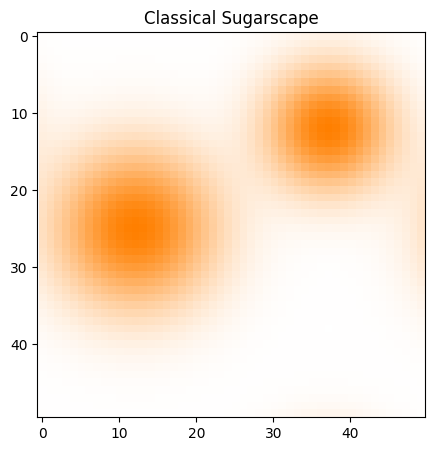

In [9]:
from matplotlib import pyplot as plt

N = 50  # Side of the sugarscape.
spot_positions = [(N //4, N // 2), (3 * N // 4, 1 * N // 4), ]  # Center of the sugar spots.
spot_widths = [N / 7, N / 9]  # Width of the sugar spots.
max_sugar = 10  # Maximum sugar level.


SuSca = initialize_sugarscape_gaussian(N, spot_positions, spot_widths, max_sugar)

print(np.max(SuSca))
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.
SuSca_RGB = convert2RBG(SuSca, RGB0, RGB1)

# Plot the Sugarscape.
plt.figure(figsize=(5, 5))
plt.imshow(SuSca_RGB)  # Plot Sugarscape profile.
# Plot the reference points.
plt.title('Classical Sugarscape')
plt.axis('equal')
plt.show()       


In [10]:
def convert2RGB(game_outcome, RGB0, RGB1):
    """
    Function to convert the 2-dimensional numpy array into an RGB image.
    
    Parameters
    ==========
    game_outcome : Outcome of the sugar distribution.
    RGB0 : Components R, G, B of the chosen color shade for minimum sugar.
    RGB1 : Components R, G, B of the chosen color shade for maximum sugar.
    """
    # Get the dimensions of the game outcome
    [n_rows, n_cols] = game_outcome.shape
    
    # Initialize the RGB image
    I_RGB = np.zeros([n_rows, n_cols, 3])
    
    # Normalize the sugar levels to be between 0 and 1
    game_outcome -= np.amin(game_outcome)    
    game_outcome /= np.amax(game_outcome)  
    
    # Map the normalized sugar levels to RGB
    for c in range(3):
        I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]

    return I_RGB

In [11]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400 # Number of agents on the sugarscape.

x_positions = np.random.randint(0, N, A)  # Random X positions
y_positions = np.random.randint(0, N, A)  # Random Y positions

# Create the agents with random integers between 1 and 5
agents = pd.DataFrame({
    "sugar": np.random.randint(1, 6, A),        # Random integers between 1 and 5 for sugar
    "metabolism": np.random.randint(1, 6, A),   # Random integers between 1 and 5 for metabolism
    "vision": np.random.randint(1, 6, A),       # Random integers between 1 and 5 for vision
    "fitness": np.zeros(A),                     # Initialize fitness to 0
    "x": x_positions,                           # X-coordinate of agent
    "y": y_positions                            # Y-coordinate of agent
})


print(agents)


     sugar  metabolism  vision  fitness   x   y
0        3           3       2      0.0  12  36
1        4           5       2      0.0   7  22
2        5           2       5      0.0  41  32
3        5           5       2      0.0  17  41
4        2           3       5      0.0  21  43
..     ...         ...     ...      ...  ..  ..
395      2           3       1      0.0  26  19
396      1           5       1      0.0  16  45
397      3           4       5      0.0   3   5
398      4           4       4      0.0  16  21
399      4           5       2      0.0  35   3

[400 rows x 6 columns]


[<Color white>, <Color #f2efef>, <Color #e9dedc>, <Color #e3ccc6>, <Color #e0bcad>, <Color #e0ad91>, <Color #e3a271>, <Color #e99c4f>, <Color #f29d29>, <Color orange>]


C:\Users\sagal\AppData\Local\Temp\ipykernel_17224\2747661489.py:66: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.7231382030880917' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  agents.at[i, "sugar"] += SuSca[new_x, new_y] #*10


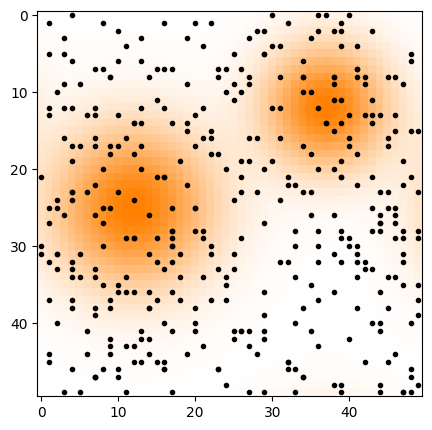

     sugar  metabolism  vision  fitness   x   y
0        3           3       2      3.0  12  36
1        4           5       2      4.0   7  22
2        5           2       5      5.0  41  32
3        5           5       2      5.0  17  41
4        2           3       5      2.0  21  43
..     ...         ...     ...      ...  ..  ..
395      2           3       1      2.0  26  19
396      1           5       1      1.0  16  45
397      3           4       5      3.0   3   5
398      4           4       4      4.0  16  21
399      4           5       2      4.0  35   3

[400 rows x 6 columns]


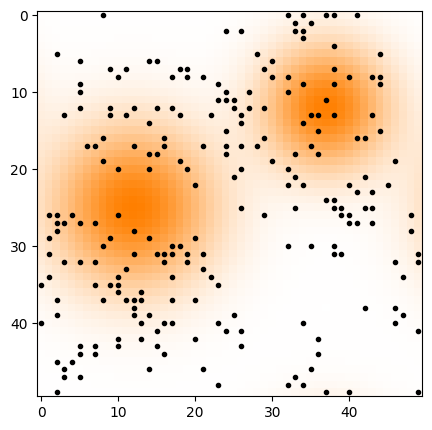

        sugar  metabolism  vision   fitness   x   y
0    1.367308           1       2  1.367308  16  44
1    2.387304           2       2  2.387304  17  31
2    0.354588           4       3  0.354588  16  17
3    1.349853           2       3  1.349853  14  29
4    4.302541           1       3  4.302541  20  22
..        ...         ...     ...       ...  ..  ..
228  4.093753           1       1  4.093753  40   8
229  0.091164           1       5  0.091164   5  27
230  0.456637           2       3  0.456637  17   8
231  2.668672           2       4  2.668672  30   8
232  2.109780           3       3  2.109780  34   0

[233 rows x 6 columns]


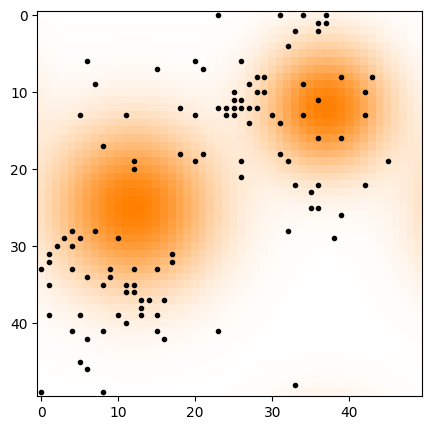

        sugar  metabolism  vision   fitness   x   y
0    2.583786           2       3  2.583786  13  39
1    1.103805           2       5  1.103805   1  32
2    1.221969           2       1  1.221969   1  35
3    1.701635           1       3  1.701635  18  18
4    3.636259           1       5  3.636259  13  38
..        ...         ...     ...       ...  ..  ..
107  1.979760           1       5  1.979760  25  12
108  3.986260           1       4  3.986260  21  18
109  4.141199           1       1  4.141199  26  19
110  2.078353           1       4  2.078353  37   0
111  3.018275           1       1  3.018275  38  29

[112 rows x 6 columns]


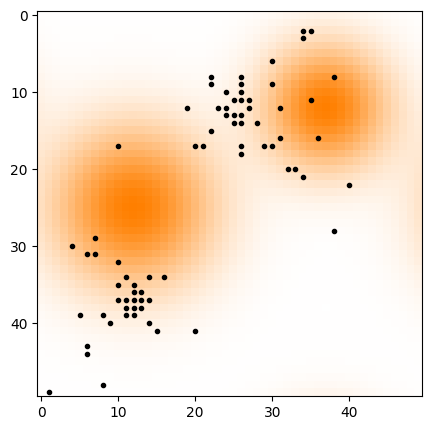

       sugar  metabolism  vision   fitness   x   y
0   3.338034           1       4  3.338034  31  12
1   1.480381           1       2  1.480381  30  17
2   0.074903           1       2  0.074903  40  22
3   0.377063           1       3  0.377063  34   3
4   0.607969           1       5  0.607969  12  37
..       ...         ...     ...       ...  ..  ..
69  2.427747           1       5  2.427747   6  31
70  0.545539           1       3  0.545539   6  43
71  0.578944           1       4  0.578944   5  39
72  3.824188           1       4  3.824188  22  15
73  0.112870           1       3  0.112870  10  32

[74 rows x 6 columns]


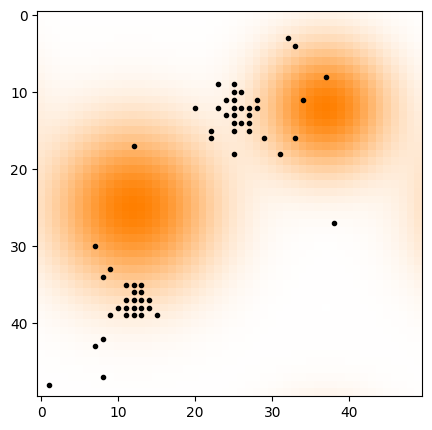

       sugar  metabolism  vision   fitness   x   y
0   1.859885           1       1  1.859885   7  30
1   1.636458           1       1  1.636458  20  12
2   1.940488           1       5  1.940488  25  12
3   1.670259           1       5  1.670259  12  35
4   3.881770           1       2  3.881770  23   9
5   0.438559           1       5  0.438559  11  37
6   2.361456           1       1  2.361456  34  11
7   3.009409           1       4  3.009409  26  12
8   2.941252           1       3  2.941252  27  13
9   1.424921           1       1  1.424921   8  47
10  1.053880           1       1  1.053880  38  27
11  3.846776           1       4  3.846776  24  11
12  0.444823           2       3  0.444823  13  39
13  2.253718           1       3  2.253718  10  38
14  2.087415           1       5  2.087415  25  11
15  0.605453           1       4  0.605453  12  39
16  1.902053           1       5  1.902053  25  10
17  4.816665           1       5  4.816665  12  38
18  1.210758           1       

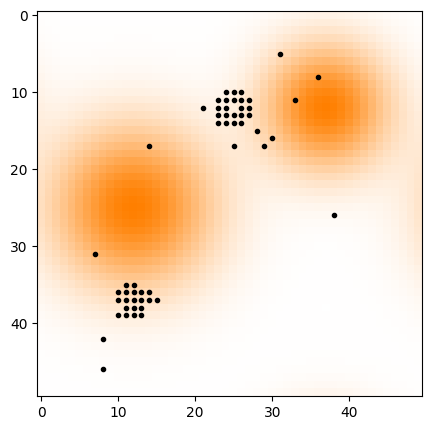

       sugar  metabolism  vision   fitness   x   y
0   1.638476           1       5  1.638476  11  36
1   3.224434           1       4  3.224434  26  11
2   2.605240           1       5  2.605240  24  12
3   4.186520           1       3  4.186520  26  13
4   1.490913           1       1  1.490913  21  12
5   2.267429           1       4  2.267429  12  35
6   3.853438           1       4  3.853438  23  12
7   2.921432           1       3  2.921432  24  13
8   0.529655           1       5  0.529655  12  36
9   0.636979           1       1  0.636979   8  46
10  0.027151           1       3  0.027151  31   5
11  0.376059           1       5  0.376059  14  37
12  3.833548           1       2  3.833548  24  10
13  0.372896           1       4  0.372896  11  37
14  3.737116           1       4  3.737116  24  14
15  2.291501           1       4  2.291501  25  14
16  2.172827           1       4  2.172827  10  36
17  1.048615           1       2  1.048615  28  15
18  0.296920           1       

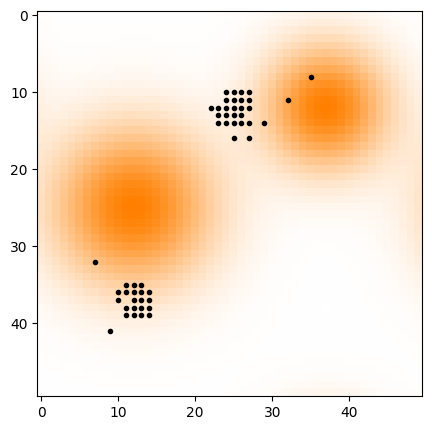

       sugar  metabolism  vision   fitness   x   y
0   1.615091           1       3  1.615091  27  16
1   0.052352           1       2  0.052352   9  41
2   3.246534           1       3  3.246534  25  12
3   3.176063           1       1  3.176063  25  16
4   0.809401           1       5  0.809401  13  35
5   0.972746           1       3  0.972746  23  13
6   2.215698           1       4  2.215698  23  14
7   3.495279           1       5  3.495279  10  37
8   1.502048           1       1  1.502048  32  11
9   4.738611           1       5  4.738611  12  39
10  3.185583           1       4  3.185583  25  14
11  2.748296           1       2  2.748296  13  37
12  2.585415           1       5  2.585415  26  11
13  0.170184           1       1  0.170184  35   8
14  1.925517           1       4  1.925517  14  38
15  3.826445           1       4  3.826445  24  12
16  0.583735           1       5  0.583735  13  38
17  3.853226           1       3  3.853226  25  13
18  4.138288           1       

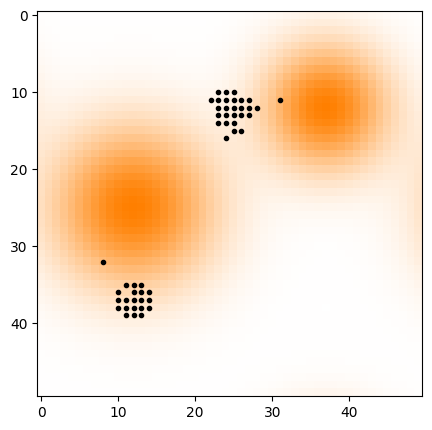

       sugar  metabolism  vision   fitness   x   y
0   0.391057           1       4  0.391057  11  37
1   0.374405           1       5  0.374405  10  38
2   3.137345           1       4  3.137345  27  13
3   2.174751           1       4  2.174751  13  39
4   3.691783           1       5  3.691783  12  36
5   1.529628           1       5  1.529628  13  36
6   1.848107           1       4  1.848107  11  39
7   2.853384           1       3  2.853384  23  11
8   2.671146           1       2  2.671146  14  38
9   3.678439           1       4  3.678439  24  11
10  0.282954           1       5  0.282954  13  37
11  0.732251           1       5  0.732251  14  36
12  3.787594           1       4  3.787594  25  14
13  3.813216           1       2  3.813216  24  12
14  4.661747           1       5  4.661747  13  35
15  1.296772           1       3  1.296772  28  12
16  2.082427           1       3  2.082427  12  39
17  1.842858           1       5  1.842858  25  11
18  2.176841           1       

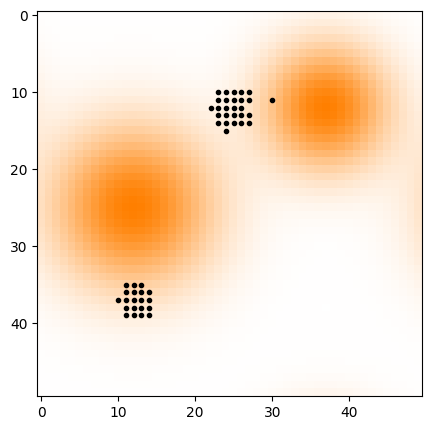

       sugar  metabolism  vision   fitness   x   y
0   0.251170           1       5  0.251170  11  36
1   0.375102           1       4  0.375102  13  37
2   3.150079           1       3  3.150079  26  14
3   4.443587           1       2  4.443587  26  10
4   3.756775           1       3  3.756775  24  14
5   2.550876           1       2  2.550876  14  39
6   0.505469           1       5  0.505469  11  37
7   4.599649           1       5  4.599649  12  35
8   1.452764           1       5  1.452764  13  35
9   1.220948           1       3  1.220948  27  10
10  0.972103           1       1  0.972103  30  11
11  0.803205           1       2  0.803205  27  14
12  2.805162           1       3  2.805162  24  10
13  1.794630           1       5  1.794630  23  11
14  3.660345           1       5  3.660345  13  36
15  1.833082           1       5  1.833082  25  11
16  1.571358           1       4  1.571358  23  13
17  3.668270           1       4  3.668270  26  12
18  4.108303           1       

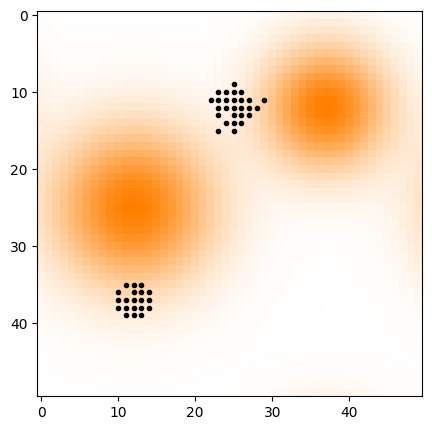

       sugar  metabolism  vision   fitness   x   y
0   1.374923           1       5  1.374923  10  36
1   3.059633           1       4  3.059633  27  12
2   3.324476           1       5  3.324476  13  35
3   3.736356           1       4  3.736356  25  14
4   0.036623           1       2  0.036623  13  38
5   1.709808           1       5  1.709808  25   9
6   2.513657           1       5  2.513657  23  11
7   1.707340           1       4  1.707340  10  38
8   3.671954           1       3  3.671954  25  15
9   4.060081           1       3  4.060081  24  14
10  1.680729           1       3  1.680729  10  37
11  3.747950           1       4  3.747950  24  11
12  2.729359           1       3  2.729359  23  10
13  2.081213           1       4  2.081213  26  13
14  2.808516           1       1  2.808516  23  15
15  0.342621           1       5  0.342621  12  37
16  4.395365           1       2  4.395365  24  10
17  1.860727           1       5  1.860727  11  38
18  1.931869           1       

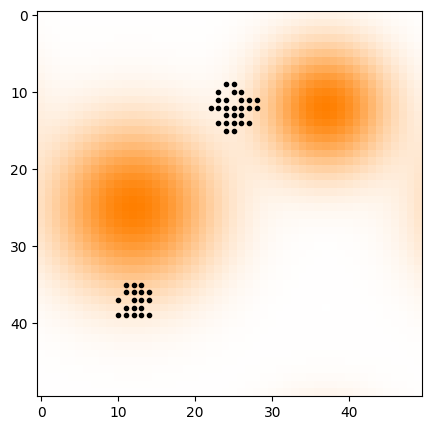

       sugar  metabolism  vision   fitness   x   y
0   1.304832           1       4  1.304832  24  13
1   4.490456           1       5  4.490456  11  36
2   2.437854           1       5  2.437854  23  14
3   1.452051           1       3  1.452051  26  14
4   3.247067           1       5  3.247067  11  35
5   0.922423           1       3  0.922423  25  13
6   3.647935           1       4  3.647935  26  12
7   3.596129           1       3  3.596129  27  14
8   1.699641           1       5  1.699641  24  12
9   0.169694           1       4  0.169694  13  35
10  1.883641           1       5  1.883641  23  11
11  3.011400           1       4  3.011400  26  10
12  2.004377           1       4  2.004377  12  36
13  2.368509           1       2  2.368509  14  39
14  2.644537           1       3  2.644537  25   9
15  2.911464           1       5  2.911464  27  12
16  3.975259           1       3  3.975259  25  15
17  2.934920           1       5  2.934920  12  39
18  0.282138           1       

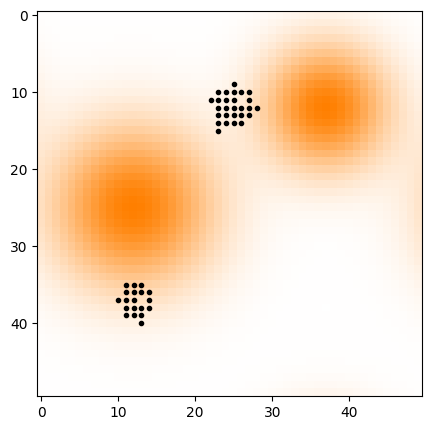

       sugar  metabolism  vision   fitness   x   y
0   2.634372           1       3  2.634372  25  11
1   1.664561           1       3  1.664561  11  37
2   2.594786           1       1  2.594786  23  15
3   2.934920           1       5  2.934920  12  37
4   3.705909           1       2  3.705909  24  10
5   0.303720           1       5  0.303720  12  39
6   3.169916           1       5  3.169916  14  36
7   2.738834           1       4  2.738834  24  11
8   1.432227           1       3  1.432227  26  13
9   1.220363           1       5  1.220363  14  38
10  1.651413           1       5  1.651413  23  13
11  3.489903           1       5  3.489903  11  39
12  3.100641           1       3  3.100641  24  12
13  1.372110           1       3  1.372110  13  39
14  3.697084           1       4  3.697084  23  12
15  3.647520           1       4  3.647520  25  12
16  1.926968           1       4  1.926968  11  35
17  1.910867           1       3  1.910867  12  36
18  3.698931           1       

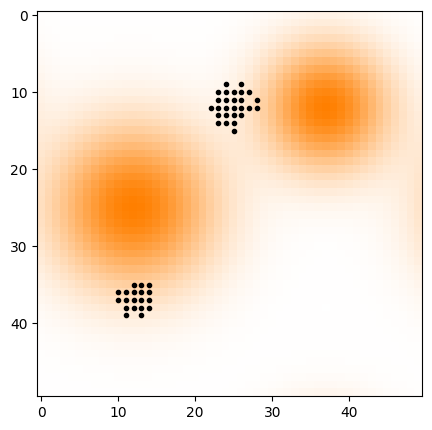

       sugar  metabolism  vision   fitness   x   y
0   3.473948           1       5  3.473948  13  37
1   3.537443           1       3  3.537443  26  11
2   3.612170           1       2  3.612170  24   9
3   2.887375           1       4  2.887375  24  10
4   2.595511           1       3  2.595511  27  12
5   2.857510           1       5  2.857510  11  39
6   2.002991           1       4  2.002991  25  11
7   0.138256           1       4  0.138256  12  37
8   0.218916           1       4  0.218916  13  36
9   0.545814           1       1  0.545814  28  11
10  1.340326           1       3  1.340326  11  38
11  2.143779           1       2  2.143779  13  39
12  0.761798           1       3  0.761798  25  15
13  0.001210           1       5  0.001210  10  36
14  1.478767           1       4  1.478767  14  35
15  0.201782           1       5  0.201782  10  37
16  1.895054           1       3  1.895054  12  38
17  1.796558           1       5  1.796558  26  10
18  1.473328           1       

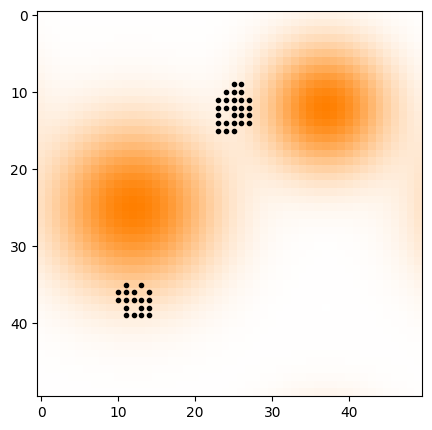

       sugar  metabolism  vision   fitness   x   y
0   4.038222           1       2  4.038222  25   9
1   1.383579           1       3  1.383579  26  14
2   3.925829           1       3  3.925829  25  12
3   2.585346           1       3  2.585346  25  13
4   1.434466           1       4  1.434466  27  12
5   3.498592           1       3  3.498592  25  10
6   0.139684           1       5  0.139684  12  39
7   0.163642           1       5  0.163642  10  37
8   0.061105           1       4  0.061105  14  38
9   3.518410           1       2  3.518410  26   9
10  2.361435           1       5  2.361435  26  11
11  2.708847           1       4  2.708847  24  11
12  2.398992           1       1  2.398992  23  15
13  1.705122           1       5  1.705122  12  37
14  1.783421           1       4  1.783421  14  36
15  2.877209           1       4  2.877209  24  12
16  2.804565           1       5  2.804565  24  10
17  1.616964           1       3  1.616964  12  36
18  0.497575           1       

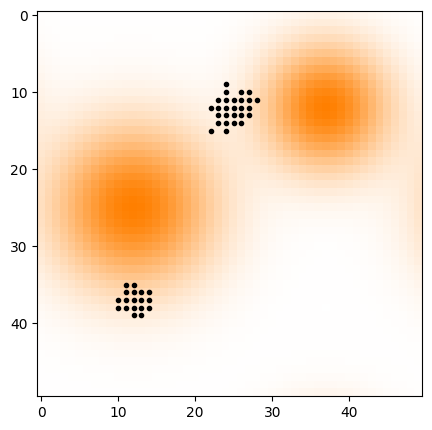

       sugar  metabolism  vision   fitness   x   y
0   4.333876           1       5  4.333876  12  38
1   0.044937           1       4  0.044937  11  37
2   1.168716           1       4  1.168716  24  13
3   2.236920           1       1  2.236920  22  15
4   3.944483           1       2  3.944483  24   9
5   1.728494           1       5  1.728494  27  13
6   1.751982           1       4  1.751982  13  36
7   1.200387           1       3  1.200387  12  35
8   2.983917           1       5  2.983917  14  36
9   1.363754           1       3  1.363754  26  13
10  1.627971           1       5  1.627971  14  38
11  2.282996           1       5  2.282996  26  14
12  2.575181           1       3  2.575181  25  11
13  1.592257           1       5  1.592257  25  13
14  0.163642           1       5  0.163642  12  37
15  1.384057           1       4  1.384057  10  37
16  0.746581           1       1  0.746581  22  12
17  1.592225           1       5  1.592225  26  12
18  0.422000           1       

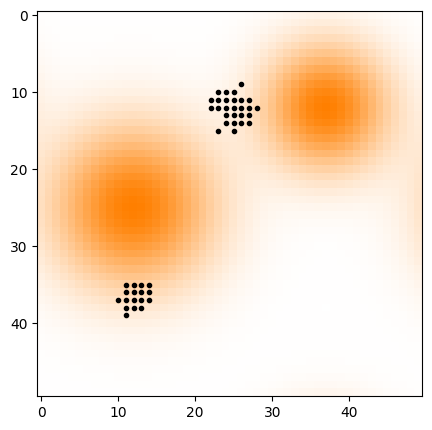

       sugar  metabolism  vision   fitness   x   y
0   3.411514           1       3  3.411514  25  10
1   0.318953           1       1  0.318953  28  12
2   1.886715           1       4  1.886715  23  11
3   1.840741           1       2  1.840741  14  35
4   3.302255           1       5  3.302255  14  37
5   4.257012           1       5  4.257012  13  35
6   0.652822           1       1  0.652822  22  11
7   0.328239           1       2  0.328239  26   9
8   1.736169           1       4  1.736169  12  38
9   3.886184           1       3  3.886184  24  11
10  1.708670           1       5  1.708670  26  11
11  0.357930           1       5  0.357930  13  36
12  1.847330           1       3  1.847330  13  37
13  3.514648           1       4  3.514648  27  13
14  2.116929           1       1  2.116929  23  15
15  1.569368           1       3  1.569368  12  36
16  2.872704           1       3  2.872704  24  12
17  2.237394           1       5  2.237394  23  10
18  1.064109           1       

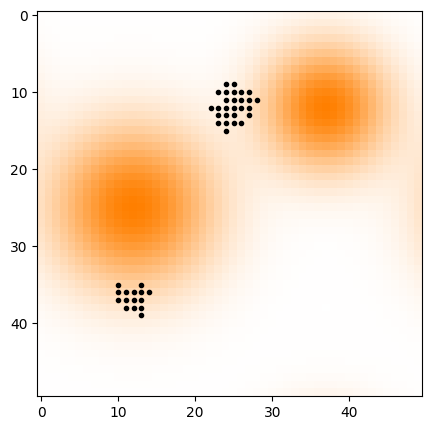

       sugar  metabolism  vision   fitness   x   y
0   3.848028           1       2  3.848028  26  10
1   0.763868           1       3  0.763868  24  10
2   2.872289           1       3  2.872289  25  12
3   1.274865           1       4  1.274865  11  38
4   2.526164           1       3  2.526164  24  12
5   1.491527           1       3  1.491527  10  36
6   3.475798           1       4  3.475798  25  14
7   3.472862           1       4  3.472862  23  13
8   0.342117           1       5  0.342117  12  36
9   3.404469           1       4  3.404469  25  13
10  2.677709           1       4  2.677709  23  14
11  4.225574           1       5  4.225574  13  36
12  1.524167           1       5  1.524167  27  13
13  2.217574           1       5  2.217574  24  13
14  3.810381           1       3  3.810381  23  10
15  0.055340           1       5  0.055340  13  35
16  1.249068           1       3  1.249068  27  10
17  2.214954           1       5  2.214954  24  11
18  1.580364           1       

In [12]:
import time
from tkinter import Tk
from tkinter import Canvas
import numpy as np

from colour import Color
white = Color("white")
cell_color_list = list(white.range_to(Color("orange"), max_sugar))

print(cell_color_list)

r0 = 0.25
N_skip = 1

# Visualize status every N_skip steps. 
window_size = 600

# Define the RGB colors for white and orange
RGB1 = [1.0, 0.5, 0.0]  # Orange for high values.
RGB0 = [1.0, 1.0, 1.0]  # White for low values.


# Normalize sugar array
normalized_sugar = SuSca / max_sugar  # Normalize to [0, 1]

# Convert the sugar array to RGB colors
color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

tk = Tk()
tk.geometry(f'{window_size + 20}x{window_size + 20}')
tk.configure(background='#000000')

canvas = Canvas(tk, background='#ECECEC')  # Generate animation window.
canvas.place(x=10, y=10, height=window_size, width=window_size)

# cell_color_list = ['#FFFFFF', '#FFECCE', '#FFCE88', '#FFA040', '#FF8000']

step = 0

def stop_loop(event):
    global running
    running = False
tk.bind("<Escape>", stop_loop)  # Bind the Escape key to stop the loop.
running = True  # Flag to control the loop.

while running:

    nSuSca, nA = move_agents(SuSca, agents, N)  # Move the agents on the sugarscape.

    # Update animation frame.
    if step % N_skip == 0:
        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(agents["x"], agents["y"], '.', color='k')
        plt.show()
        
        canvas.delete('all')
        SU_cells = []

        # Normalize sugar array
        normalized_sugar = nSuSca / max_sugar  # Normalize to [0, 1]

        # Convert the sugar array to RGB colors
        color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

        # Use the converted RGB image to draw the cells
        for i in range(N):
            for j in range(N):
                # Get the color from the RGB image
                cell_color = color_image[i, j]
                hex_color = f'#{int(cell_color[0]*255):02x}{int(cell_color[1]*255):02x}{int(cell_color[2]*255):02x}'
                
                SU_cells.append(
                    canvas.create_rectangle(
                        i / N * window_size, 
                        j / N * window_size,
                        (i + 1) / N * window_size,
                        (j + 1) / N * window_size, 
                        outline='', 
                        fill=hex_color,
                    )
                )

        # Update the agents
        Agents_circ = []
        for _, agent in agents.iterrows():  # Iterating through each row in the DataFrame
            x = agent["x"]  # X-coordinate of the agent
            y = agent["y"]  # Y-coordinate of the agent

            # Drawing the agent as a circle
            Agents_circ.append(
                canvas.create_oval(
                    (x + 0.5 - r0) / N * window_size,  # Top-left x-coordinate
                    (y + 0.5 - r0) / N * window_size,  # Top-left y-coordinate
                    (x + 0.5 + r0) / N * window_size,  # Bottom-right x-coordinate
                    (y + 0.5 + r0) / N * window_size,  # Bottom-right y-coordinate
                    outline='', 
                    fill='#000000',
                )
            )

        tk.title(f'Iteration {step}')
        tk.update_idletasks()
        tk.update()
        time.sleep(0.5)  # Increase to slow down the simulation.

    agents['fitness'] = agents.apply(calculate_fitness, axis=1)
    print(agents)


    agents = nA
    step += 1 
    
    # after some steps, apply the GA logic
    if step >30:
        parents = select_parents(agents, 10)
        new_agents = []
        for i in range(0, len(parents), 2):
            parent1 = parents.iloc[i]
            parent2 = parents.iloc[i + 1]
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)
            new_agents.append(child1)
            new_agents.append(child2)
        agents = replace_population(agents, pd.DataFrame(new_agents))  # Keeping the old agents and adding the new ones to the population --> Population size grows each round
        print(agents)
    
    # Periodically regenerate sugar hotspots
    if step % 20 == 0:  # Regenerate every 20 steps
        SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)


tk.update_idletasks()
tk.update()
tk.mainloop()  # Release animation handle (close window to finish).


In [13]:
# import time
# from tkinter import Tk, Canvas
# import numpy as np
# import pandas as pd  # Assuming agents are stored in a DataFrame

# # Parameters
# r0 = 0.25
# N_skip = 1
# window_size = 600
# RGB1 = [1.0, 0.5, 0.0]  # Orange for high sugar
# RGB0 = [1.0, 1.0, 1.0]  # White for low sugar

# def convert2RGB(game_outcome, RGB0, RGB1):
#     """
#     Convert the sugar levels into an RGB color map dynamically.
#     """
#     game_outcome -= np.amin(game_outcome)
#     game_outcome /= np.amax(game_outcome)
#     I_RGB = np.zeros((*game_outcome.shape, 3))
#     for c in range(3):
#         I_RGB[:, :, c] = game_outcome * RGB1[c] + (1 - game_outcome) * RGB0[c]
#     return I_RGB

# # Function to dynamically update the canvas
# def update_canvas(canvas, SuSca, agents, SU_cells, Agents_circ, N, window_size):
#     """
#     Update the canvas dynamically for Sugarscape and agents.
#     """
#     # Normalize sugar levels for RGB mapping
#     normalized_sugar = SuSca / np.max(SuSca)
#     color_image = convert2RGB(normalized_sugar, RGB0, RGB1)

#     # Clear old sugar cells
#     for cell in SU_cells:
#         canvas.delete(cell)
#     SU_cells.clear()

#     # Update Sugarscape
#     for i in range(N):
#         for j in range(N):
#             if SuSca[i, j] > 0:
#                 cell_color = color_image[i, j]
#                 hex_color = f'#{int(cell_color[0] * 255):02x}{int(cell_color[1] * 255):02x}{int(cell_color[2] * 255):02x}'
#                 SU_cells.append(
#                     canvas.create_rectangle(
#                         i / N * window_size,
#                         j / N * window_size,
#                         (i + 1) / N * window_size,
#                         (j + 1) / N * window_size,
#                         outline='',
#                         fill=hex_color
#                     )
#                 )

#     # Clear old agent circles
#     for circ in Agents_circ:
#         canvas.delete(circ)
#     Agents_circ.clear()

#     # Update agents
#     for _, agent in agents.iterrows():
#         x, y = agent["x"], agent["y"]
#         Agents_circ.append(
#             canvas.create_oval(
#                 (x + 0.5 - r0) / N * window_size,
#                 (y + 0.5 - r0) / N * window_size,
#                 (x + 0.5 + r0) / N * window_size,
#                 (y + 0.5 + r0) / N * window_size,
#                 outline='',
#                 fill='#000000'
#             )
#         )

# # Initialize Tkinter
# tk = Tk()
# tk.geometry(f'{window_size + 20}x{window_size + 20}')
# tk.configure(background='#000000')

# canvas = Canvas(tk, background='#ECECEC')
# canvas.place(x=10, y=10, height=window_size, width=window_size)

# # Initial state
# step = 0
# running = True
# SU_cells = []
# Agents_circ = []

# # Stop loop on Escape key
# def stop_loop(event):
#     global running
#     running = False
# tk.bind("<Escape>", stop_loop)

# # Animation loop
# while running:
#     # Update Sugarscape and agents
#     nSuSca, nA = move_agents(SuSca, agents, N)

#     if step % N_skip == 0:
#         update_canvas(canvas, SuSca, agents, SU_cells, Agents_circ, N, window_size)
#         tk.title(f'Iteration {step}')
#         tk.update_idletasks()
#         tk.update()
#         time.sleep(0.1)  # Adjust this for speed

#     # Update agents with fitness
#     agents['fitness'] = agents.apply(calculate_fitness, axis=1)

#     # Apply genetic algorithm after some steps
#     if step > 30:
#         parents = select_parents(agents, 10)
#         new_agents = []
#         for i in range(0, len(parents), 2):
#             parent1 = parents.iloc[i]
#             parent2 = parents.iloc[i + 1]
#             child1, child2 = crossover(parent1, parent2)
#             child1 = mutate(child1)
#             child2 = mutate(child2)
#             new_agents.extend([child1, child2])
#         agents = replace_population(agents, pd.DataFrame(new_agents))

#     # Regenerate sugar hotspots periodically
#     if step % 20 == 0:
#         SuSca = regenerate_hotspots(SuSca, N=50, num_hotspots=3, max_sugar=10, peak_value=5, sigma=4)

#     agents = nA
#     step += 1

# # Close Tkinter when finished
# tk.update_idletasks()
# tk.update()
# tk.mainloop()


Now let's try without animation.

In [14]:
from random import sample

N = 50  # Size of the sugarscape with the agents.
A = 400  # Number of agents on the sugarscape.

# Initial values. Chosen from the following flat distributions.
possible_m = np.arange(4) + 1  # Metabolic rate.
possible_v = np.arange(6) + 1  # Vision.
possible_s = np.arange(21) + 5  # Sugar.

# Agents initialized. 
M = np.random.randint(np.size(possible_m), size=A) + 1
V = np.random.randint(np.size(possible_v), size=A) + 1
S = np.random.randint(np.size(possible_s), size=A) + 5

M0 = M.copy()
S0 = S.copy()
V0 = V.copy()

# Define agents position. 
L = np.array(sample(range(N * N), A)).astype(int) 
x = L % N
y = ((L - x) / N).astype(int) 
# This way each agent occupy a different cell.

SuSca = initialize_sugarscape(N)

# Number of agents
num_agents = 400

# Create a DataFrame with random values for each attribute
agents = pd.DataFrame({
    "sugar": np.random.uniform(0, 1, num_agents),       # Random sugar values
    "metabolism": np.random.uniform(0, 1, num_agents), # Random metabolism values
    "vision": np.random.uniform(0, 1, num_agents),     # Random vision values
    "fitness": np.zeros(num_agents)                    # Initialize fitness to 0
})


NameError: name 'initialize_sugarscape' is not defined

In [ ]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
    
# Create the image of the game outcome.
RGB1 = [1.0, 0.5, 0.0]  # Orange. Color for high values.
RGB0 = [1.0, 1.0, 1.0]  # White. Color for low values.

MAX_STEP = 1001
N_skip = 200
step = 0

N_alive_agents = np.zeros(MAX_STEP)


running = True  # Flag to control the loop.
while running:

    N_alive_agents[step] = A

    nSuSca, nA, nV, nS, nM, nx, ny = move_agents(SuSca, A, V, S, M, x, y)

    if step % N_skip == 0:   
        SuSca_RGB = convert2RBG(nSuSca, RGB0, RGB1)

        plt.figure(figsize=(5, 5))
        plt.imshow(SuSca_RGB)
        plt.plot(ny, nx, '.', color='k')
        plt.show()
    
    
    A = nA
    V = nV.copy()
    S = nS.copy()
    M = nM.copy()
    x = nx.copy()
    y = ny.copy()
    step += 1
    
    if step >= MAX_STEP:
        running = False

        
# Final Values
M1 = M.copy()
S1 = S.copy()
V1 = V.copy()



TypeError: move_agents() takes from 3 to 4 positional arguments but 7 were given

Compare histograms:

In [ ]:
print(A)

301


#### Metabolism

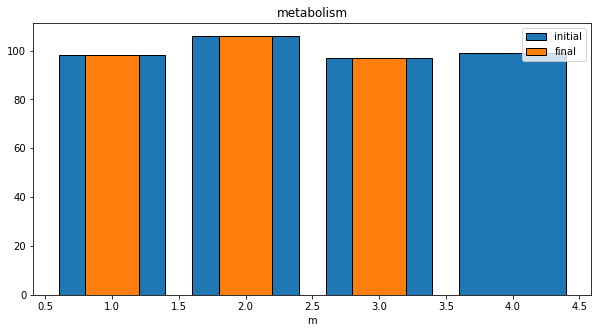

In [ ]:
# Metabolism: initial and final distribution.
m_bins = possible_m
m_bins_edges = np.arange(np.amin(possible_m) - 0.5, np.amax(possible_m) + 0.6)
m_ini_h, m_ini_e = np.histogram(M0, bins=m_bins_edges)
m_fin_h, m_fin_e = np.histogram(M1, bins=m_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(m_bins, m_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(m_bins, m_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('m')
plt.title('metabolism')
plt.show()





#### Vision

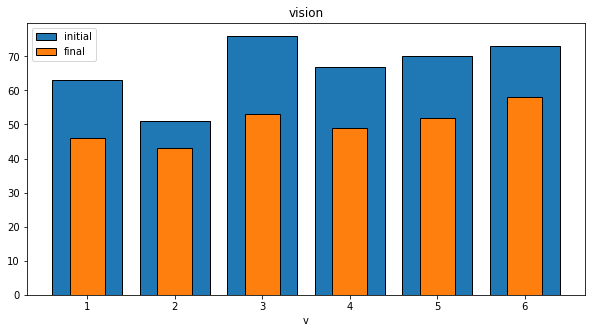

In [ ]:
# Vision: initial and final distribution.
v_bins = possible_v
v_bins_edges = np.arange(np.amin(possible_v) - 0.5, np.amax(possible_v) + 0.6)
v_ini_h, v_ini_e = np.histogram(V0, bins=v_bins_edges)
v_fin_h, v_fin_e = np.histogram(V1, bins=v_bins_edges)


plt.figure(figsize=(10, 5))
plt.bar(v_bins, v_ini_h, width=0.8, edgecolor='k', label='initial')
plt.bar(v_bins, v_fin_h, width=0.4, edgecolor='k', label='final')
plt.legend()
plt.xlabel('v')
plt.title('vision')
plt.show()


#### Sugar

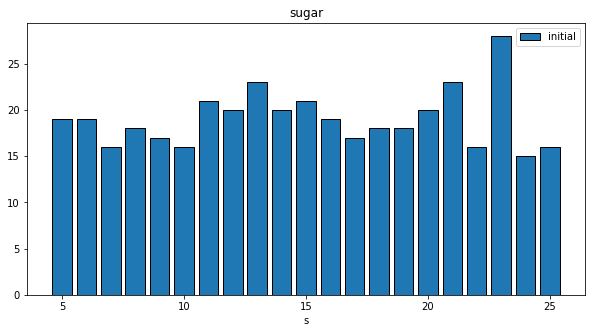

In [ ]:
# Sugar: initial and final distribution.
s_bins_i = possible_s
s_bins_edges_i = np.arange(np.amin(possible_s) - 0.5, np.amax(possible_s) + 0.6)
s_ini_h, s_ini_e = np.histogram(S0, bins=s_bins_edges_i)

plt.figure(figsize=(10, 5))
plt.bar(s_bins_i, s_ini_h, width=0.8, edgecolor='k', label='initial')
plt.legend()
plt.xlabel('s')
plt.title('sugar')
plt.show()




### Lorenz curve and Gini coefficient.

Measure of equality in wealth / resources distribution 

In [ ]:
def Lorenz_curve(s):
    """
    Function to generate the Lorenz curve from a sequence of data.
    
    Parameters
    ==========
    s : Sugar of each agent.
    """
    
    N = np.size(s)
    
    population_fraction = np.arange(N) / N
    
    s_sorted = np.sort(s)
    
    cumulative_s_fraction = np.cumsum(s_sorted) / np.sum(s_sorted)
    
    
    return cumulative_s_fraction, population_fraction

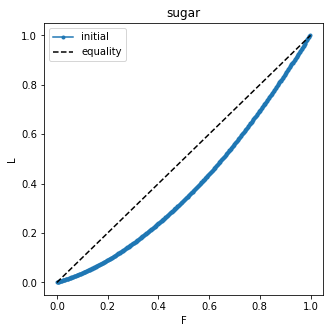

In [ ]:
L0, F0 = Lorenz_curve(S0)


plt.figure(figsize=(5, 5))
plt.plot(F0, L0, '.-', label='initial')
plt.plot([0, 1], [0, 1], '--', color='k', label='equality')
plt.legend()
plt.xlabel('F')
plt.ylabel('L')
plt.title('sugar')
plt.show()


